In [9]:
import matplotlib.pyplot as plt 
import os
import numpy as np
import os
import glob
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [10]:
from PIL import Image

#path to the image.
def callImage(path):
    x1 = Image.open(
        path).convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));
    y_dat1 = np.asarray(y1, dtype=np.uint8)     
    return y_dat1

#Resize image into n x n pixel ( pixel is an int)
def imageResize(data,pixel):
    image = Image.fromarray(data,'L')
    image= image.resize((pixel, pixel))
    image=np.asarray(image.getdata(), dtype=np.float64).reshape((image.size[1], image.size[0]))
    image=np.asarray(image, dtype=np.uint8)    
    return image

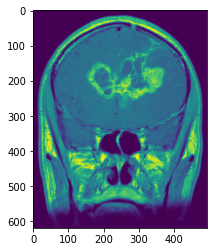

In [11]:
data_img = callImage("image.jpg")
plt.imshow(data_img)

In [12]:
image = imageResize(data_img,16) # Can be printed with plt.imshow(image)
image.flatten()

array([  0,   0,   0,   0,   1,  42,  78,  83,  89,  79,  42,   3,   0,
         0,   0,   0,   0,   0,   0,  37,  96, 113,  99,  87,  91, 100,
       108, 104,  45,   0,   0,   0,   0,   0,  63, 111,  96,  88,  93,
        98,  95,  92, 102, 104, 105,  65,   1,   0,   0,  47, 106,  92,
        93, 101, 107, 100, 105, 120, 117,  92,  83,  87,  44,   0,  15,
        84,  76,  93,  99, 139, 124, 123, 103, 104, 157, 157,  96,  77,
        77,  11,  55,  93,  80,  95,  99, 138, 120, 158, 177, 130, 160,
       157,  89,  78,  78,  50,  72, 110,  77,  90,  95, 102, 121, 123,
       143, 143, 112,  91,  87,  75, 100,  75,  75, 117,  73,  94,  88,
        97, 101,  96, 103,  94,  91,  89,  90,  75, 114,  75,  80, 133,
        69,  86,  83,  95, 100,  81,  83,  94,  92,  84,  82,  75, 127,
        79,  83, 178,  81,  72,  84, 110,  55,  24,   9,  46, 111,  80,
        67,  84, 167,  98,  72, 150, 101, 136, 149, 127, 102,  57,  43,
        87, 146, 140, 123,  98, 148,  82,  56, 130,  88, 145, 19

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import  Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator

nqubits=8

In [14]:
def phaseFlip(testdata):
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,8) for x in arr_data]);
    sum_const=np.sqrt(sum(np.absolute(encoding_data) ** 2))
    encoding_norm=encoding_data/sum_const
    m=np.diag(np.exp(complex(0,1)*np.pi*encoding_norm))
    return m

In [15]:
def convert_to_circuit(image):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    m = phaseFlip(np.array(image))
    #Initilzation
    qc = QuantumCircuit(qr, name='UI')
    #qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
    qc.unitary(m, range(nqubits), label='UI')
    print(qc)
    return qc

    
    

In [16]:
qc= convert_to_circuit(image)
qc = qc.decompose()


      ┌─────┐
q0_0: ┤0    ├
      │     │
q0_1: ┤1    ├
      │     │
q0_2: ┤2    ├
      │     │
q0_3: ┤3    ├
      │  UI │
q0_4: ┤4    ├
      │     │
q0_5: ┤5    ├
      │     │
q0_6: ┤6    ├
      │     │
q0_7: ┤7    ├
      └─────┘


In [17]:
# GREY_THRESHOLD = 0.33
# WHITE_THRESHOLD = 0.66

# x_train_bin = np.array([ (math.pi / 2) if x_train > WHITE_THRESHOLD else 0 if x_train<GREY_THRESHOLD else (math.pi / 4) ], dtype=np.float32)
# x_test_bin = np.array([0 if x_train > WHITE_THRESHOLD else (math.pi / 2) if x_train<GREY_THRESHOLD else (math.pi / 4) ], dtype=np.float32)

In [18]:
# def convert_to_circuit(image):
#     """Encode truncated classical image into quantum datapoint."""
#     values = np.ndarray.flatten(image)
#     circuit = Circuit().h(range(9))
#     for i, value in enumerate(values):
#         circuit.ry(i, value)
#         circuit.X(i)
#     return circuit
!pip install toolz

In [24]:

def qotp_encrypt(qc,keys):
        
    """
            keys: QOTP encryption keys
            keys[0]: indicates X gates (ai)
            keys[1]: indicates z gates (bi)
            Example: keys=[[1,0,1,1],[0,0,1,1]] -> X - X X, - - Z Z
            len(keys)=2
            len(keys[0])=nqubits
    """


    for i in range(len(keys[0])):
            if keys[0][i]==1:
                qc.x(i)
            if  keys[1][i]==1:
                qc.z(i)
            #qc.barrier()



def update_h(j):
        """Update the keys after applying hadamard gate

        Args:
            j (int): qubit index
        """        
    
        x= keys[0][j] #keys[0] indicates x gates, keys[0][0]-> X gate on the first qubit
        keys[0][j]= keys[1][j]
        keys[1][j]=x

def update_cx(j):
        """Update the keys after applying CNOT gate

        Args:
            j (int): qubit index
        """        
    
        keys[1][j]=( keys[1][j]+ keys[1][j+1])%2
        keys[0][j+1]=( keys[0][j]+ keys[0][j+1])%2
    
    
    
    
    

def update_cz(j,m):
        # j: control, m:target 
       
        keys[1][j]= keys[1][j]*  keys[0][m]
        keys[1][m]= keys[1][m]*  keys[0][j]

def decrypt(qc,keys):
            """
            keys: updated decrypted key
            """


            for i in range(len(keys[0])):
                if keys[0][i]==1:
                    qc.x(i)
                if  keys[1][i]==1:
                    qc.z(i)
            #qc.barrier()

In [49]:
from collections import OrderedDict
from toolz import partition
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import  Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator

nqubits=8

keys=[[0,1,1,1,0,1,1,0],[0,1,1,1,0,1,1,0]] #testing example

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        update_h(qubit)

    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    update_h(nqubits-1)

    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
   
    qc.h(nqubits-1)
    update_h(nqubits-1)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        update_h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s


def phaseFlipM(testdata):
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,8) for x in arr_data]);
    sum_const=np.sqrt(sum(np.absolute(encoding_data) ** 2))
    encoding_norm=encoding_data/sum_const
    m=np.diag(np.exp(complex(0,1)*np.pi*encoding_norm))
    return m

def grover(itr,data):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    m = phaseFlipM(np.array(data))
    #Initilzation
    qc = QuantumCircuit(qr, name='UI1')


    qotp_encrypt(qc,keys,)

    #qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
    qc.unitary(m, range(nqubits), label='UI2')

    my_inst = qc.to_instruction()

    #Grover Search
    my_circuit = QuantumCircuit(qr,cr)
    for qubit in range(nqubits):
        my_circuit.h(qubit)

    for i in range(itr):
        my_circuit.append(my_inst, range(nqubits))
        my_circuit.append(diffuser(nqubits), range(nqubits))


    decrypt(qc,keys)

    my_circuit.measure(qr[:],cr[:])
    nshot=100000;
    print(my_circuit)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(my_circuit, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    return count

def countBitstring(count):
    f=[]
    for i in range(2**nqubits):
        if format(i, '#010b')[2:10] in count:
            f.append(count[format(i, '#010b')[2:10]])
        else:
            f.append(0)
    return np.array(list(f))

def imigize1(count):
    countlist=countBitstring(count)
    out_img=np.array(list(partition(16, countlist)))/max(countlist);
    return out_img.squeeze()

In [50]:
grover(5, image)


       ┌───┐┌──────┐┌───────────┐┌──────┐┌───────────┐┌──────┐┌───────────┐»
q75_0: ┤ H ├┤0     ├┤0          ├┤0     ├┤0          ├┤0     ├┤0          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q75_1: ┤ H ├┤1     ├┤1          ├┤1     ├┤1          ├┤1     ├┤1          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q75_2: ┤ H ├┤2     ├┤2          ├┤2     ├┤2          ├┤2     ├┤2          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q75_3: ┤ H ├┤3     ├┤3          ├┤3     ├┤3          ├┤3     ├┤3          ├»
       ├───┤│  UI1 ││  Diffuser ││  UI1 ││  Diffuser ││  UI1 ││  Diffuser │»
q75_4: ┤ H ├┤4     ├┤4          ├┤4     ├┤4          ├┤4     ├┤4          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q75_5: ┤ H ├┤5     ├┤5          ├┤5     ├┤5          ├┤5     ├┤5          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»

{'00000011': 397,
 '11110011': 381,
 '10100000': 383,
 '11100110': 407,
 '01101010': 391,
 '11000101': 373,
 '11000100': 357,
 '01011110': 404,
 '01010100': 431,
 '11010100': 298,
 '11011110': 380,
 '01010001': 368,
 '01101101': 410,
 '10100100': 353,
 '01101000': 358,
 '00100110': 389,
 '01100110': 418,
 '10001010': 394,
 '10011001': 345,
 '11101111': 413,
 '10010000': 404,
 '11011100': 443,
 '00100100': 420,
 '00001000': 378,
 '11001101': 408,
 '11001001': 428,
 '01001011': 403,
 '01001010': 380,
 '01011100': 403,
 '11110100': 409,
 '01100011': 405,
 '11110110': 335,
 '00001100': 371,
 '11010000': 390,
 '00000010': 389,
 '00011010': 409,
 '10000010': 404,
 '01011010': 403,
 '00111110': 372,
 '11111000': 393,
 '00110100': 358,
 '11100100': 431,
 '11111011': 385,
 '01110110': 420,
 '01010010': 423,
 '00001101': 419,
 '11110101': 379,
 '10111000': 390,
 '00101100': 461,
 '00110010': 381,
 '11111100': 373,
 '00011100': 397,
 '11000000': 402,
 '10000101': 458,
 '11010001': 392,
 '11101010

       ┌───┐┌──────┐┌───────────┐┌──────┐┌───────────┐┌──────┐┌───────────┐»
q76_0: ┤ H ├┤0     ├┤0          ├┤0     ├┤0          ├┤0     ├┤0          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q76_1: ┤ H ├┤1     ├┤1          ├┤1     ├┤1          ├┤1     ├┤1          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q76_2: ┤ H ├┤2     ├┤2          ├┤2     ├┤2          ├┤2     ├┤2          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q76_3: ┤ H ├┤3     ├┤3          ├┤3     ├┤3          ├┤3     ├┤3          ├»
       ├───┤│  UI1 ││  Diffuser ││  UI1 ││  Diffuser ││  UI1 ││  Diffuser │»
q76_4: ┤ H ├┤4     ├┤4          ├┤4     ├┤4          ├┤4     ├┤4          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»
q76_5: ┤ H ├┤5     ├┤5          ├┤5     ├┤5          ├┤5     ├┤5          ├»
       ├───┤│      ││           ││      ││           ││      ││           │»

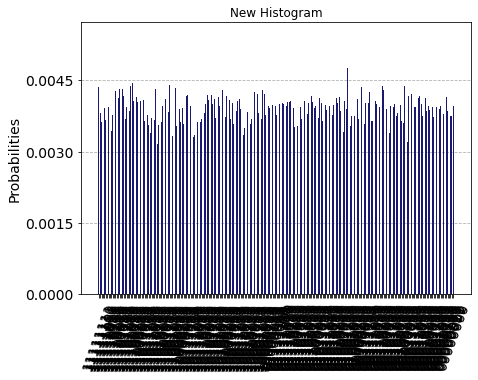

In [51]:
plot_histogram(grover(5,image), color='midnightblue', title="New Histogram",bar_labels =False,sort = 'desc')

       ┌───┐┌─┐                     
q77_0: ┤ H ├┤M├─────────────────────
       ├───┤└╥┘┌─┐                  
q77_1: ┤ H ├─╫─┤M├──────────────────
       ├───┤ ║ └╥┘┌─┐               
q77_2: ┤ H ├─╫──╫─┤M├───────────────
       ├───┤ ║  ║ └╥┘┌─┐            
q77_3: ┤ H ├─╫──╫──╫─┤M├────────────
       ├───┤ ║  ║  ║ └╥┘┌─┐         
q77_4: ┤ H ├─╫──╫──╫──╫─┤M├─────────
       ├───┤ ║  ║  ║  ║ └╥┘┌─┐      
q77_5: ┤ H ├─╫──╫──╫──╫──╫─┤M├──────
       ├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐   
q77_6: ┤ H ├─╫──╫──╫──╫──╫──╫─┤M├───
       ├───┤ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q77_7: ┤ H ├─╫──╫──╫──╫──╫──╫──╫─┤M├
       └───┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
c77_0: ══════╩══╬══╬══╬══╬══╬══╬══╬═
                ║  ║  ║  ║  ║  ║  ║ 
c77_1: ═════════╩══╬══╬══╬══╬══╬══╬═
                   ║  ║  ║  ║  ║  ║ 
c77_2: ════════════╩══╬══╬══╬══╬══╬═
                      ║  ║  ║  ║  ║ 
c77_3: ═══════════════╩══╬══╬══╬══╬═
                         ║  ║  ║  ║ 
c77_4: ══════════════════╩══╬══╬══╬═
                            ║  ║  ║ 
c

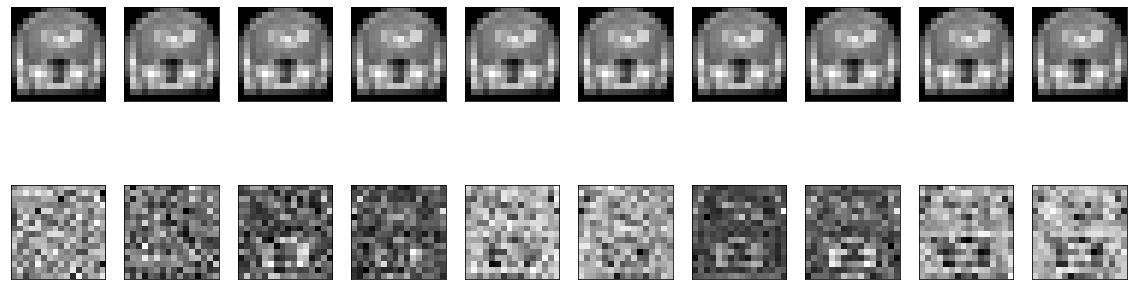

In [52]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(10):

    axes[0,i].imshow(image, cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(imigize1(grover(i,image)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])